In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation, NMF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_data(df):
    # One-hot encoding for the 'sentiment' column
    df = pd.get_dummies(df, columns=['sentiment'])

    # Perform TF-IDF vectorization on the textual features
    vectorizer = TfidfVectorizer()
    text_features = vectorizer.fit_transform(df['reviews.text'])

    # Split the data into features and target
    X = df.drop(['name', 'brand', 'categories', 'primaryCategories',
                 'reviews.date', 'reviews.title', 'reviews.text'], axis=1)
    y = X[['sentiment_Negative', 'sentiment_Neutral', 'sentiment_Positive']]
    X = X.drop(['sentiment_Negative', 'sentiment_Neutral', 'sentiment_Positive'], axis=1)

    # Encode non-numeric columns
    non_numeric_cols = ['lda_topic', 'nmf_topic']
    label_encoders = {}
    for col in non_numeric_cols:
        label_encoders[col] = LabelEncoder()
        X[col] = label_encoders[col].fit_transform(X[col])

    # Combine the TF-IDF features with the remaining numeric features
    X = np.hstack((X.values, text_features.toarray()))

    # Split the data into training, validation, and test sets
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import numpy as np

def train_model(X_train, y_train, X_val, y_val, model_type='SVM'):
    if model_type == 'SVM':
        tfidf_vectorizer = TfidfVectorizer()
        X_train_text = [' '.join(str(text) for text in item) for item in X_train]
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
        
        X_val_text = [' '.join(str(text) for text in item) for item in X_val]
        X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
        
        svm = OneVsRestClassifier(SVC(kernel='linear', probability=True))
        svm.fit(X_train_tfidf, y_train)
        return svm
    elif model_type == 'NeuralNet':
        model = Sequential()
        model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(3, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stop = EarlyStopping(patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32,
                            callbacks=[early_stop], verbose=0)
        return model, history
    else:
        raise ValueError("Invalid model type. Supported types are 'SVM' and 'NeuralNet'.")


In [4]:
def evaluate_modelNeural(model, X_test, y_test):
    # Plot training and validation accuracy and loss
    plt.plot(model.history.history['accuracy'], label='Training Accuracy')
    plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot(model.history.history['loss'], label='Training Loss')
    plt.plot(model.history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Use the model to make predictions on the test data
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Print the classification report
    print(classification_report(np.argmax(y_test.values, axis=1), y_pred, zero_division=1))

    # Save the trained model to a file
    save_model(model, 'Neuralnet.h5')

    # Create the confusion matrix
    conf_mat = confusion_matrix(np.argmax(y_test.values, axis=1), y_pred)

    # Create a list of class labels
    class_names = ['Negative', 'Neutral', 'Positive']

    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


In [11]:
# from sklearn.metrics import precision_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle

# def evaluate_modelSVM(model, X_train, y_train, X_val, y_val, X_test, y_test):
#     # Train the SVM classifier for multiple epochs
#     num_epochs = 2
#     train_precision_list = []
#     val_precision_list = []
#     for epoch in range(num_epochs):
#         # Train the model
#         model.fit(X_train, y_train)

#         # Get predictions on training and validation data
#         train_predictions = model.predict(X_train)
#         val_predictions = model.predict(X_val)

#         # Calculate precision for training and validation data
#         train_precision = precision_score(y_train, train_predictions, average='weighted', zero_division=0)
#         val_precision = precision_score(y_val, val_predictions, average='weighted', zero_division=0)

#         # Print epoch results
#         print(f"Epoch number {epoch+1}, training precision = {train_precision:.4f}, validation precision = {val_precision:.4f}")

#         # Add precision scores to the lists
#         train_precision_list.append(train_precision)
#         val_precision_list.append(val_precision)

#     # Plot training and validation precision over epochs
#     plt.plot(range(1, num_epochs + 1), train_precision_list, label='Training Precision')
#     plt.plot(range(1, num_epochs + 1), val_precision_list, label='Validation Precision')
#     plt.legend()
#     plt.title('SVM - Training and Validation Precision')
#     plt.xlabel('Epoch')
#     plt.ylabel('Precision')
#     plt.show()

#     # Use the model to make predictions on the test data
#     y_pred = model.predict(X_test)

#     # Print the classification report
#     print(classification_report(y_test, y_pred))

#     # Save the trained model to a file
#     with open('SVM.pkl', 'wb') as f:
#         pickle.dump(model, f)

#     # Create the confusion matrices
#     conf_mat = multilabel_confusion_matrix(y_test, y_pred)

#     # Create a list of class labels
#     class_names = ['Negative', 'Neutral', 'Positive']

#     # Create heatmaps of the confusion matrices
#     for i, conf in enumerate(conf_mat):
#         plt.figure()
#         sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#         plt.xlabel('Predicted Class')
#         plt.ylabel('True Class')
#         plt.title(f'Confusion Matrix - Class {i}')
#         plt.show()


In [ ]:
from sklearn.metrics import precision_score, classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

def evaluate_modelSVM(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Train the SVM classifier for multiple epochs
    num_epochs = 2
    train_precision_list = []
    val_precision_list = []
    for epoch in range(num_epochs):
        # Train the model
        model.fit(X_train, y_train)

        # Get predictions on training and validation data
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Calculate precision for training and validation data
        train_precision = precision_score(y_train, train_predictions, average='weighted', zero_division=0)
        val_precision = precision_score(y_val, val_predictions, average='weighted', zero_division=0)

        # Print epoch results
        print(f"Epoch number {epoch+1}, training precision = {train_precision:.4f}, validation precision = {val_precision:.4f}")

        # Add precision scores to the lists
        train_precision_list.append(train_precision)
        val_precision_list.append(val_precision)

    # Plot training and validation precision over epochs
    plt.plot(range(1, num_epochs + 1), train_precision_list, label='Training Precision')
    plt.plot(range(1, num_epochs + 1), val_precision_list, label='Validation Precision')
    plt.legend()
    plt.title('SVM - Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.show()

    # Use the model to make predictions on the test data
    y_pred = model.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Save the trained model to a file
    with open('SVM.pkl', 'wb') as f:
        pickle.dump(model, f)

    # Create the confusion matrices
    conf_mat = multilabel_confusion_matrix(y_test, y_pred)

    # Create a list of class labels
    class_names = ['Negative', 'Neutral', 'Positive']

    # Create heatmaps of the confusion matrices
    for i, conf in enumerate(conf_mat):
        plt.figure()
        sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.title(f'Confusion Matrix - Class {i}')
        plt.show()


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

def perform_topic_modeling(df):
    # Preprocess text data
    vectorizer = CountVectorizer()
    review_vectors = vectorizer.fit_transform(df['reviews.text'])
    review_vectors = review_vectors.toarray()

    # Perform topic modeling using LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda_topics = lda.fit_transform(review_vectors)
    lda_topic_labels = ['Topic {}'.format(i) for i in np.argmax(lda_topics, axis=1)]
    df['lda_topic'] = lda_topic_labels

    # Perform topic modeling using NMF
    nmf = NMF(n_components=5, random_state=42, max_iter=500)  # Increase max_iter to improve convergence
    nmf_topics = nmf.fit_transform(review_vectors)
    nmf_topic_labels = ['Topic {}'.format(i) for i in np.argmax(nmf_topics, axis=1)]
    df['nmf_topic'] = nmf_topic_labels

    return df


In [7]:
# def main():
#     # Load the data from the CSV file
#     df = pd.read_csv('Ecommerce/train_data.csv')

#     # Perform topic modeling
#     df = perform_topic_modeling(df)

#     # Preprocess the data
#     X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df)

#     # Train the SVM model
#     svm_model = train_model(X_train, y_train, X_val, y_val, model_type='SVM')

#     # Train the Neural Network model
#     nn_model, history = train_model(X_train, y_train, X_val, y_val, model_type='NeuralNet')

#     # Evaluate the Neural Network model
#     evaluate_modelNeural(nn_model, X_test, y_test)
    
#     # Evaluate the SVM model
#     evaluate_modelSVM(svm_model, X_train, y_train, X_val, y_val, X_test, y_test)


# if __name__ == '__main__':
#     main()

In [8]:
# Load the data from the CSV file
df = pd.read_csv('Ecommerce/train_data.csv')

# Perform topic modeling
df = perform_topic_modeling(df)

# Preprocess the data
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df)

# Train the SVM model
svm_model = train_model(X_train, y_train, X_val, y_val, model_type='SVM')

# Train the Neural Network model
nn_model, history = train_model(X_train, y_train, X_val, y_val, model_type='NeuralNet')

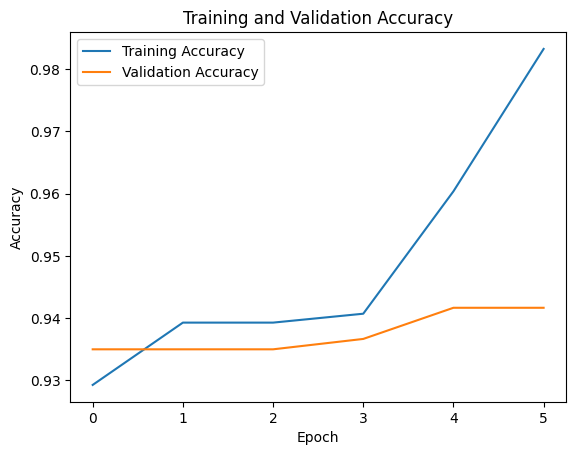

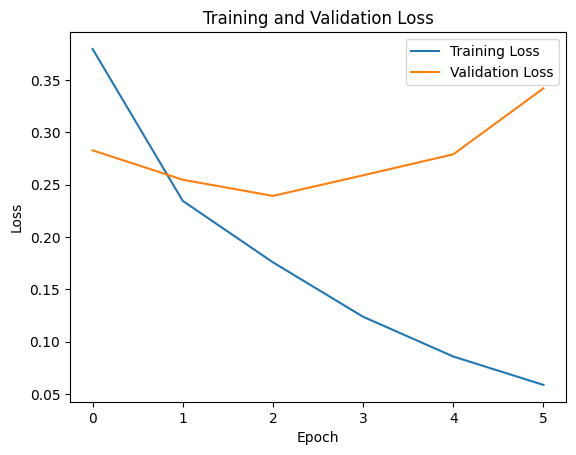

19/19 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         9
           1       1.00      0.00      0.00        33
           2       0.93      1.00      0.96       558

    accuracy                           0.93       600
   macro avg       0.98      0.33      0.32       600
weighted avg       0.93      0.93      0.90       600



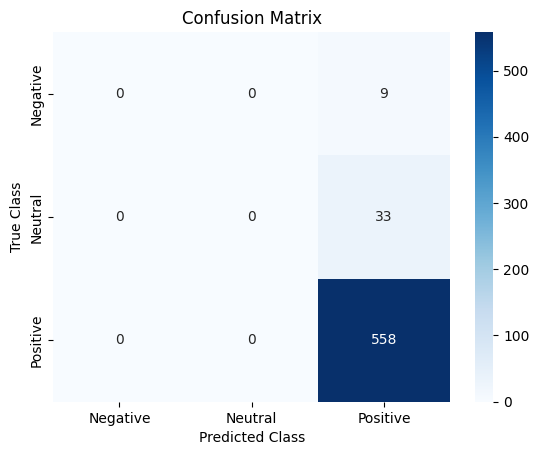

In [9]:
# Evaluate the Neural Network model
evaluate_modelNeural(nn_model, X_test, y_test)

In [ ]:
# Evaluate the SVM model
evaluate_modelSVM(svm_model, X_train, y_train, X_val, y_val, X_test, y_test)